In [1]:
import xarray as xr
import numpy as np
%pylab inline
pylab.rcParams['figure.figsize'] = (18.0, 10.0); # Large figures

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os

# gx3v7 output; daily averages
filename = os.path.expanduser('~/')+'MARBL_data/POP_hist.nc'
if not os.path.isfile(filename):
    casename='C1850ECO.T62_g37.ciso.marbl_dev_levy'
    rundir='/glade2/scratch2/mlevy/%s/run' % casename
    date='0001-01-02'
    filename = '%s/%s.pop.h.%s.nc' % (rundir, casename, date)

if os.path.isfile(filename):
    print("Opening %s" % filename)
    ds = xr.open_dataset(filename, decode_times=False, decode_coords=False)
else:
    print("Can not find %s" % filename)

Opening /Users/mlevy/MARBL_data/POP_hist.nc


In [3]:
# Functions for altering data

def pressure(depth):
    """
    ! !DESCRIPTION:
    !  This function computes pressure in bars from depth in meters
    !  using a mean density derived from depth-dependent global
    !  average temperatures and salinities from Levitus 1994, and
    !  integrating using hydrostatic balance.
    !
    !  References:
    !
    !     Levitus, S., R. Burgett, and T.P. Boyer, World Ocean Atlas
    !          1994, Volume 3: Salinity, NOAA Atlas NESDIS 3, US Dept. of
    !          Commerce, 1994.
    !
    !     Levitus, S. and T.P. Boyer, World Ocean Atlas 1994,
    !          Volume 4: Temperature, NOAA Atlas NESDIS 4, US Dept. of
    !          Commerce, 1994.
    !
    !     Dukowicz, J. K., 2000: Reduction of Pressure and Pressure
    !          Gradient Errors in Ocean Simulations, J. Phys. Oceanogr.,
    !          submitted.
    """
    # Taken from pressure() in POP's state_mod.F90
    # Note that this function returns value in units of atm rather than bars
    # [consistent with units of atmospheric pressure]
    return(0.059808*(exp(-0.025*depth)-1.) + 0.100766*depth + 2.28405e-7*depth*depth)

def xkw_to_u10sqr(xkw):
    # in marbl_diagnostics_mod.F90: diags(ind_diag%ECOSYS_XKW)%field_2d(:) = piston_velocity(:)
    # in marbl_mod.F90:             piston_velocity = xkw_coeff*u10_sqr(:)
    # in marbl_settings_mod.F90:    xkw_coeff =   6.97e-9_r8 ! in s/cm, from a = 0.251 cm/hr s^2/m^2 in Wannikhof 2014
    xkw_coeff = 6.97e-9 # s/cm
    # Note that this function returns value in units m^/s^2 rather than cm^2/s^2
    return((xkw/xkw_coeff)*0.0001)

def get_surface_value(data_in, column_var):
    # first just populate it with SHF_QSW(another scalar) to get all metadata
    new_ds = data_in['SHF_QSW'].copy(deep=True)
    new_ds.values = data_in[column_var].values[0]
    new_ds.attrs['long_name'] = data_in[column_var].attrs['long_name']
    new_ds.attrs['units'] = data_in[column_var].attrs['units']
    try:
        new_ds.encoding['scale_factor'] = data_in[column_var].encoding['scale_factor']
    except:
        pass
    return(new_ds)

In [4]:
# Variables to keep (POP Variable Names)
grid_vars = ['TLAT', 'TLONG', 'z_t', 'z_t_150m', 'z_w_bot', 'dz']
forcing_vars = ['ECOSYS_XKW', 'ATM_FINE_DUST_FLUX_CPL', 'ATM_COARSE_DUST_FLUX_CPL', 
                'SEAICE_DUST_FLUX_CPL', 'SHF_QSW', 'TEMP', 'SALT', 'ECOSYS_ATM_PRESS',
                'ECOSYS_IFRAC', 'IRON_FLUX', 'NOx_FLUX', 'NHy_FLUX', 'ATM_CO2', 'ATM_ALT_CO2']
base_tracers = ['PO4', 'NO3', 'SiO3', 'NH4', 'Fe', 'Lig', 'O2', 'DIC', 'DIC_ALT_CO2', 'ALK', 'ALK_ALT_CO2',
                'DOC', 'DON', 'DOP', 'DOPr', 'DONr', 'DOCr', 'zooC', 'spChl', 'spC', 'spP', 'spFe', 'spCaCO3',
                'diatChl', 'diatC', 'diatP', 'diatFe', 'diatSi', 'diazChl', 'diazC', 'diazP', 'diazFe']
ciso_tracers = ['DI13C', 'DO13C', 'DI14C', 'DO14C', 'zoo13C', 'zoo14C', 'sp14C', 'sp14C',
                'spCa13CO3', 'spCa14CO3', 'diat13C', 'diat14c', 'diaz13C', 'diaz14C']
vars_to_keep = grid_vars + forcing_vars + base_tracers + ciso_tracers
# Pick a (lat, lon)
# gx3v7
# (17,18) is Southern Ocean (28.1 E, 50.576 S); has 56 levels
# (19,50) is near SOFS site SW of Tasmania (143.3 E, 45.695 S); has 54 levels
# ---
# gx1v7
# (53, 60) is Southern Ocean (28.1 E, 50.907 S); has 58 levels
# (63, 163) is near SOFS site SW of Tasmania (143.9 E, 45.564 S); has 55 levels

lat_in = 53
lon_in = 60

lon = ds.isel(time=0, nlat=lat_in, nlon=lon_in)['TLONG'].values
lat = ds.isel(time=0, nlat=lat_in, nlon=lon_in)['TLAT'].values
depth_cnt = ds.isel(time=0, nlat=lat_in, nlon=lon_in)['KMT'].values

# Verify location
print('(lon, lat) = ({:.1f}, {:.3f})'.format(lon, lat))
print('There are {} levels'.format(depth_cnt))

# Set up separate data sets for forcing and initial conditions
#forcing_col = raw_data.copy(deep=True)
#forcing_col.drop([v for v in raw_data.variables if v not in grid_vars + forcing_vars])

(lon, lat) = (28.1, -50.907)
There are 55.0 levels


In [5]:
# Reduce data
raw_data = ds.isel(time=0, nlat=lat_in, nlon=lon_in).drop([v for v in ds.variables if v not in vars_to_keep])
for var_name in raw_data.variables:
    if 'coordinates' in raw_data[var_name].attrs:
        del(raw_data[var_name].attrs['coordinates'])

# unit conversion
# cm to m
for varname in ['z_t', 'z_t_150m', 'z_w_bot', 'dz']:
    raw_data[varname].values = raw_data[varname].values*0.01
    raw_data[varname].attrs['units'] = 'm'

# nmol/cm^2/s to mmol/m^2/s
for varname in ['NOx_FLUX', 'NHy_FLUX']:
    raw_data[varname].values = raw_data[varname].values*0.01
    raw_data[varname].attrs['units'] = 'mmol/m^2/s'

# g/cm^2/s to kg/m^2/s
for varname in ['ECOSYS_XKW', 'ATM_FINE_DUST_FLUX_CPL', 'ATM_COARSE_DUST_FLUX_CPL', 'SEAICE_DUST_FLUX_CPL']:
    raw_data[varname].values = raw_data[varname].values*10.
    raw_data[varname].attrs['units'] = 'kg/m^2/s'

# salinity units should be psu
raw_data['SALT'].attrs['units'] = 'psu'

# Add SST, SSS, u10_sqr and pressure to dataset
raw_data['SST'] = get_surface_value(raw_data, 'TEMP')
raw_data['SSS'] = get_surface_value(raw_data, 'SALT')

# u10_sqr
varname = 'U10_SQR'
# first just populate it with SHF_QSW(another scalar) to get all metadata
raw_data[varname] = raw_data['SHF_QSW']
raw_data[varname].values = xkw_to_u10sqr(raw_data['ECOSYS_XKW'].values)
raw_data[varname].attrs['long_name'] = '10m wind speed squared'
raw_data[varname].attrs['units'] = 'm^2/s^2'

# pressure
varname = 'pressure'
# first just populate it with TEMP (another 1D var) to get all metadata
raw_data[varname] = raw_data['TEMP']
raw_data[varname].values = np.where(np.isnan(raw_data[varname].values),
                                      np.nan,
                                      pressure(raw_data['z_t'].values))
raw_data[varname].attrs['long_name'] = 'Pressure'
raw_data[varname].attrs['units'] = 'bars'

In [6]:
raw_data.to_netcdf('raw_data.nc')

# Variables to keep (MARBL variable names)
grid_vars_to_MARBL = {'lat': 'TLAT', 'lon' : 'TLONG', 'z_t' : 'z_t', 'delta_z' : 'dz'}
forcing_vars_to_MARBL = {'u10_sqr' : 'U10_SQR', 'temperature' : 'TEMP', 'salinity' : 'SALT', 'atm_pressure' : 'ECOSYS_ATM_PRESS',
                         'ice_frac' : 'ECOSYS_IFRAC', 'iron_flux' : 'IRON_FLUX', 'nox_flux' : 'NOx_FLUX', 'nhy_flux' : 'NHy_FLUX',
                         'atm_co2' : 'ATM_CO2', 'atm_alt_co2' : 'ATM_CO2', 'pressure' : 'pressure'}
# ['ECOSYS_XKW', 'ATM_FINE_DUST_FLUX_CPL', 'ATM_COARSE_DUST_FLUX_CPL', 
#  'SEAICE_DUST_FLUX_CPL', 'SHF_QSW', 'TEMP', 'SALT', 'ECOSYS_ATM_PRESS',
#  'ECOSYS_IFRAC', 'IRON_FLUX', 'NOx_FLUX', 'NHy_FLUX', 'ATM_CO2', 'ATM_ALT_CO2']
tracers_MARBL = base_tracers + ciso_tracers

MARBL_data = raw_data.copy(deep=True).drop(raw_data.variables)
for MARBL_name, POP_name in grid_vars_to_MARBL.items():
    MARBL_data[MARBL_name] = raw_data[POP_name]
for MARBL_name, POP_name in forcing_vars_to_MARBL.items():
    MARBL_data[MARBL_name] = raw_data[POP_name]

# dust flux is sum of atm fine dust, atm coarse dust, and seaice dust fluxes
MARBL_data['dust_flux'] = raw_data['ATM_FINE_DUST_FLUX_CPL'] + raw_data['ATM_COARSE_DUST_FLUX_CPL'] + \
                          raw_data['SEAICE_DUST_FLUX_CPL']
MARBL_data['dust_flux'].attrs = raw_data['ATM_FINE_DUST_FLUX_CPL'].attrs
MARBL_data['dust_flux'].attrs['long_name'] = 'Dust Flux'

MARBL_data.rename({'z_t' : 'zt'}, inplace=True)
MARBL_data.to_netcdf('marbl.nc')

In [7]:
def update_xlim(interior_forcing):
    if interior_forcing == 'tmperature':
        plt.xlim(0, 13)
    if interior_forcing == 'salinity':
        plt.xlim(34, 35)
    if interior_forcing == 'pressure':
        plt.xlim(0,400)

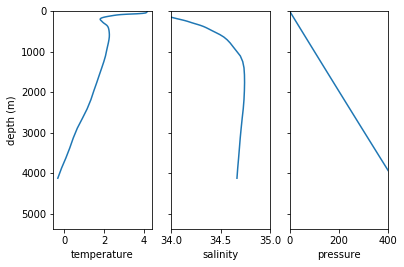

In [8]:
fig, axes = plt.subplots(ncols=3)
plt.xlim(400000,0)

for n, interior_forcing in enumerate(['temperature', 'salinity', 'pressure']):
    MARBL_data[interior_forcing].plot(ax=axes[n])
    plt.subplot(1,3,n+1);
    plt.plot(MARBL_data[interior_forcing].values, MARBL_data['zt'].values);
    plt.ylim(max(MARBL_data['zt'].values), min(MARBL_data['zt'].values));
    plt.xlabel(interior_forcing)
    # Only want y-axis label and tick labels on left-most plot
    plt.ylabel("depth (m)" if (n == 0) else "")
    plt.tick_params(labelleft=(n == 0))
        
    update_xlim(interior_forcing);